In [1]:
import numpy as np
import torch
from torch import nn
from TorinoEnvironment_eucnc import TorinoEnvironment
import import_ipynb
import ActorCriticModel
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

importing Jupyter notebook from ActorCriticModel.ipynb


In [2]:
hidden_size = 64
learning_rate_actor = 1e-3
learning_rate_critic = 1e-3
max_episodes = 200
gamma = 0.5

actions = [-5, -3, -1, 0, 1, 3, 5]
#actions = list(range(-5, 5))
action_size = len(actions)
state_size = 2

train_env, test_env = TorinoEnvironment(), TorinoEnvironment()

train_env.head(.8)
test_env.tail(.8)

55659
13915


In [3]:
# env_work = TorinoEnvironment().getWork()
# largest_diff = 0
# index = 0
# for i in range(len(env_work) - 1):
#     if abs(env_work[i] - env_work[i+1]) > largest_diff:
#         largest_diff = abs(env_work[i] - env_work[i+1])
#         index = i
# print("Largest difference in work at index", i, "with a difference of ", largest_diff[0])

In [4]:
def entropy(x):
    logx = torch.log(x)
    Hx = torch.sum(x*logx)
    return Hx

In [5]:
def train(env, learning_rate_actor, learning_rate_critic, state_size, action_size, hidden_size, max_episodes, gamma, load_models=False):
    actor = ActorCriticModel.Actor(state_size, action_size, hidden_size, temperature=0.9)
    critic = ActorCriticModel.Critic(state_size, action_size, hidden_size)
    
    #actor_critic = ActorCriticModel.ActorCritic(state_size, action_size, hidden_size, temperature=0.9)
    print(actor)
    print(critic)
    #print(actor_critic)
    
    if load_models:
        actor.load_state_dict(torch.load('actor_state_dict_EUCNC_compare_results'))
        critic.load_state_dict(torch.load('critic_state_dict_EUCNC_compare_results'))
        actor_critic.load_state_dict(torch.load('actor_critic_state_dict_EUCNC_compare_results'))



    optimizer_actor = torch.optim.Adam(actor.parameters(), lr=learning_rate_actor) # Consider if Adam is best optimizer here
    optimizer_critic = torch.optim.Adam(critic.parameters(), lr=learning_rate_critic)
    #optimizer = torch.optim.Adam(actor_critic.parameters(), lr=learning_rate_actor)
    
    rewards_episodes_avg = []
    rewards_episodes_min = []
    rewards_episodes_max = []

    losses_actor = []
    losses_critic = []
    #losses = []

    
    for episode in range(max_episodes):
        print("#################")
        print("## Episode %03d ##" % episode)
        print("#################")
        print("[TRAINING]")
        env.resetState()

        W = int(env.monitorState('instant_work'))
        N = W + 1
        state  = np.array((W, N))

        rewards = []
        values = []
        action_probs = []
        entropies = []
        k = 0.01

        for step in tqdm(range(env.duration)):
        #for step in tqdm(range(500)):
            state = torch.from_numpy(state).float()
            action_dist = actor.forward(state)
            #action_dist, value = actor_critic.forward(state)

            if action_dist.isnan().any():
                break
    
            value = critic.forward(state)
            values.append(value)
            
            action = np.random.choice(actions, p=np.squeeze(action_dist.detach().cpu().numpy()))
            action_probs.append(action_dist[actions.index(action)])

            entropies.append(entropy(action_dist))

            env.evolveState(nrOfCPUs=int(state.cpu().numpy()[1]) + action)
            
            reward = env.getReward()
            rewards.append(reward)

            W = int(env.monitorState('instant_work'))
            N = len(env.monitorState('CPUload'))
            state = np.array((W, N))

        print("min reward episode: ", np.amin(rewards))
        print("max reward episode: ", np.amax(rewards))
        print("avg reward episode: ", np.mean(rewards))

        rewards_episodes_avg.append(np.mean(rewards)) 
        rewards_episodes_min.append(np.amin(rewards))
        rewards_episodes_max.append(np.amax(rewards))

        
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        #optimizer.zero_grad()
        loss_actor, loss_critic = ActorCriticModel.calc_loss(torch.stack(action_probs), 
                                          torch.cat(values), 
                                          torch.tensor(rewards).float(),
                                          gamma)
        
        loss_entropy = torch.mean(torch.stack(entropies))
        loss = loss_actor + loss_critic + loss_entropy*k
        print("total_loss ", loss.item(), "| actor_loss ", loss_actor.item(), "| critic_loss ", loss_critic.item())
        losses_actor.append(loss_actor.item())
        losses_critic.append(loss_critic.item())
        #losses.append(loss.item())
        loss.backward()
        optimizer_actor.step()
        optimizer_critic.step()
        #optimizer.step()

        torch.save(actor.state_dict(), 'actor_state_dict_EUCNC_compare_results')
        torch.save(critic.state_dict(), 'critic_state_dict_EUCNC_compare_results')
        #torch.save(actor_critic.state_dict(), 'actor_critic_state_dict_EUCNC_compare_results')

        if episode%50 == 0:
            val(test_env)
    
    plt.plot(losses_actor, label="loss actor")
    plt.legend()
    plt.savefig("loss_actor_EUCNC_comparison")
    plt.show()
    plt.plot(losses_critic, label="loss critic")
#    plt.plot(losses, label = "losses")
    plt.legend()
    plt.savefig("loss_EUCNC_comparison")
    plt.show()

    return rewards_episodes_avg, rewards_episodes_min, rewards_episodes_max

In [6]:
def val(env):

    print("[VALIDATION]")
    # Load models
    actor = ActorCriticModel.Actor(state_size, action_size, hidden_size)
    actor.load_state_dict(torch.load('actor_state_dict_EUCNC_compare_results'))
    actor.eval()
    
    critic = ActorCriticModel.Critic(state_size, action_size, hidden_size)
    critic.load_state_dict(torch.load('critic_state_dict_EUCNC_compare_results'))
    critic.eval()

#     actor_critic = ActorCriticModel.ActorCritic(state_size, action_size, hidden_size)
#     actor_critic.load_state_dict(torch.load('actor_critic_state_dict_EUCNC_compare_results'))
#     actor_critic.eval()
    
    rewards_episodes_avg = []
    rewards_episodes_min = []
    rewards_episodes_max = []

    losses_actor = []
    losses_critic = []
#    losses = []
    
    env.resetState()

    W = int(env.monitorState('instant_work'))
    N = W + 1
    state  = np.array((W, N))

    rewards = []
    values = []
    action_probs = []

    with torch.no_grad():
        for step in tqdm(range(env.duration)):
            state = torch.from_numpy(state).float()
            action_dist = actor.forward(state)
            #action_dist, value = actor_critic.forward(state)
    
            if action_dist.isnan().any():
                break
    
            value = critic.forward(state)
            values.append(value)
            
            #action = np.random.choice(actions, p=np.squeeze(action_dist.detach().cpu().numpy()))
            action = actions[np.argmax(action_dist.detach().cpu().numpy())]
            action_probs.append(action_dist[actions.index(action)])
    
            env.evolveState(nrOfCPUs=int(state.cpu().numpy()[1]) + action)
            
            reward = env.getReward()
            rewards.append(reward)
    
            W = int(env.monitorState('instant_work'))
            N = len(env.monitorState('CPUload'))
            state = np.array((W, N))
    
        print("min reward episode: ", np.amin(rewards))
        print("max reward episode: ", np.amax(rewards))
        print("avg reward episode: ", np.mean(rewards))

        rewards_episodes_avg.append(np.mean(rewards)) 
        rewards_episodes_min.append(np.amin(rewards))
        rewards_episodes_max.append(np.amax(rewards))

        loss_actor, loss_critic = ActorCriticModel.calc_loss(torch.stack(action_probs), 
                                          torch.cat(values), 
                                          torch.tensor(rewards).float(),
                                          gamma)
        
        loss = loss_actor + loss_critic
        print("total_loss ", loss.item(), "| actor_loss ", loss_actor.item(), "| critic_loss ", loss_critic.item())
        losses_actor.append(loss_actor.item())
        losses_critic.append(loss_critic.item())
        #losses.append(loss.item())

In [7]:
def test(env, save=True):

    # Load models
    actor = ActorCriticModel.Actor(state_size, action_size, hidden_size)
    actor.load_state_dict(torch.load('actor_state_dict_EUCNC_compare_results'))
    actor.eval()
    
    critic = ActorCriticModel.Critic(state_size, action_size, hidden_size)
    critic.load_state_dict(torch.load('critic_state_dict_EUCNC_compare_results'))
    critic.eval()

#     actor_critic = ActorCriticModel.ActorCritic(state_size, action_size, hidden_size)
#     actor_critic.load_state_dict(torch.load('actor_critic_state_dict_EUCNC_compare_results'))
#     actor_critic.eval()
    
    # Run test environment
    env.resetState()
    traceNrOfCPUs = np.zeros((env.duration,))
    traceMaxCPUload = np.zeros((env.duration,))
    traceSumBacklog = np.zeros((env.duration,))
    traceReward = np.zeros((env.duration,))
    
    W = int(env.monitorState('instant_work'))
    N = W + 1
    state  = np.array((W, N))
    rewards = []
    delays = []
    time = 0

    #while not env.stop:
    for step in tqdm(range(env.duration)):
        state = torch.from_numpy(state).float()
        action_dist = actor.forward(state)
        #action_dist, value = actor_critic.forward(state)
        value = critic.forward(state)
        #action = np.random.choice(actions, p=np.squeeze(action_dist.detach().numpy()))
        action = actions[np.argmax(action_dist.detach().cpu().numpy())]
        
        env.evolveState(nrOfCPUs=int(state.numpy()[1]) + action)
          
        reward = env.getReward()
        rewards.append(reward)
        
        W = int(env.monitorState('instant_work'))
        N = len(env.monitorState('CPUload'))
        state = np.array((W, N))    
     
        traceNrOfCPUs[time] = state[1]
        traceMaxCPUload[time] = np.max(env.monitorState('CPUload'))
        traceSumBacklog[time] = np.sum(env.monitorState('backlog'))
        traceReward[time] = env.getReward()
        
        #delays.append(env.delay)
        
        time += 1

    if save:
        #add in all other plots to compare
        pd.DataFrame({
            'nrOfCPUs': traceNrOfCPUs,
            'maxCPUload': traceMaxCPUload,
            'sumBacklog': traceSumBacklog,
            'reward': traceReward,
        }).to_csv('eucnc2020-csvs/A2C.csv')

In [20]:
def visualize(rewards_episodes_avg, rewards_episodes_min, rewards_episodes_max):    
    #smoothed_rewards = pd.Series.rolling(pd.Series(rewards_episodes), 10).mean() # hier zou alle rewards weer meegenomen moeten worden
    #smoothed_rewards = [elem for elem in smoothed_rewards]
    
    plt.plot(rewards_episodes_avg, label="Average reward per episode")
    plt.plot(rewards_episodes_min, label="Minimum reward per episode")
    plt.plot(rewards_episodes_max, label="Maximum reward per episode")
    #plt.plot(smoothed_rewards)
    plt.legend()
    plt.ylim(-20, 1.1)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.savefig("rewards_episodes_EUCNCcomparison")
    plt.show()

Actor(
  (linear1): Linear(in_features=2, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=7, bias=True)
  (relu): ELU(alpha=1.0)
  (softmax): Softmax(dim=0)
)
Critic(
  (linear1): Linear(in_features=2, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ELU(alpha=1.0)
)
#################
## Episode 000 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1648.29it/s]


min reward episode:  0.0
max reward episode:  0.8682801338453705
avg reward episode:  0.13181208101881867
total_loss  -0.34384506940841675 | actor_loss  -0.6559532880783081 | critic_loss  0.3249777555465698
[VALIDATION]


100%|██████████| 13915/13915 [00:05<00:00, 2572.57it/s]


min reward episode:  -259.1657351724717
max reward episode:  0.5686097360607643
avg reward episode:  -3.9353857010995013
total_loss  2870.248779296875 | actor_loss  -10.81871223449707 | critic_loss  2881.0673828125
#################
## Episode 001 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1725.86it/s]


min reward episode:  0.0
max reward episode:  0.7708828011477595
avg reward episode:  0.13454974452949908
total_loss  1.5090173482894897 | actor_loss  1.0503594875335693 | critic_loss  0.4754096269607544
#################
## Episode 002 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1666.72it/s]


min reward episode:  -877.7795233425682
max reward episode:  0.9800000000000002
avg reward episode:  -6.489081879585605
total_loss  5067.244140625 | actor_loss  -24.58489227294922 | critic_loss  5091.8466796875
#################
## Episode 003 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1600.63it/s]


min reward episode:  -661.6651357165449
max reward episode:  1.0
avg reward episode:  -5.96787100960443
total_loss  3685.90869140625 | actor_loss  -22.066303253173828 | critic_loss  3707.99267578125
#################
## Episode 004 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1684.81it/s]


min reward episode:  -347.9617515018807
max reward episode:  1.0
avg reward episode:  -3.6284070548981027
total_loss  1083.3067626953125 | actor_loss  -12.80130672454834 | critic_loss  1096.1251220703125
#################
## Episode 005 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1740.66it/s]


min reward episode:  -360.58356661859966
max reward episode:  1.0
avg reward episode:  -1.72741235793281
total_loss  383.8906555175781 | actor_loss  -5.133625030517578 | critic_loss  389.040771484375
#################
## Episode 006 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1834.58it/s]


min reward episode:  -152.2382112108849
max reward episode:  1.0
avg reward episode:  -0.7987693454928321
total_loss  121.39961242675781 | actor_loss  -1.1809660196304321 | critic_loss  122.59674072265625
#################
## Episode 007 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1659.13it/s]


min reward episode:  -168.59262599299888
max reward episode:  1.0
avg reward episode:  -0.509712267050954
total_loss  119.22325897216797 | actor_loss  0.18346402049064636 | critic_loss  119.05573272705078
#################
## Episode 008 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1618.09it/s]


min reward episode:  -110.45981705431055
max reward episode:  0.9999999999999998
avg reward episode:  -0.35016476172887484
total_loss  58.181549072265625 | actor_loss  0.9342260956764221 | critic_loss  57.2631721496582
#################
## Episode 009 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1642.49it/s]


min reward episode:  -92.25664744539871
max reward episode:  1.0
avg reward episode:  -0.11680234964362442
total_loss  33.03583526611328 | actor_loss  1.804084062576294 | critic_loss  31.247570037841797
#################
## Episode 010 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1704.86it/s]


min reward episode:  -89.29309908504634
max reward episode:  1.0
avg reward episode:  -0.06828407792774928
total_loss  28.99329948425293 | actor_loss  1.9800995588302612 | critic_loss  27.028947830200195
#################
## Episode 011 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1583.40it/s]


min reward episode:  -47.389957759826935
max reward episode:  0.9999999999999999
avg reward episode:  0.06444134066432243
total_loss  19.37340545654297 | actor_loss  2.352630853652954 | critic_loss  17.03642463684082
#################
## Episode 012 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1645.17it/s]


min reward episode:  -55.668728301916175
max reward episode:  1.0
avg reward episode:  0.09794243788753115
total_loss  17.649450302124023 | actor_loss  2.303699493408203 | critic_loss  15.361434936523438
#################
## Episode 013 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1779.25it/s]


min reward episode:  -40.3179589581101
max reward episode:  1.0
avg reward episode:  0.1139616530141694
total_loss  15.357049942016602 | actor_loss  2.1632297039031982 | critic_loss  13.209437370300293
#################
## Episode 014 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1648.10it/s]


min reward episode:  -37.32009003815552
max reward episode:  0.9999999999999999
avg reward episode:  0.18700921623876907
total_loss  12.798815727233887 | actor_loss  2.1979119777679443 | critic_loss  10.61648178100586
#################
## Episode 015 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1726.65it/s]


min reward episode:  -44.89704059893186
max reward episode:  1.0
avg reward episode:  0.18381275901166555
total_loss  12.340470314025879 | actor_loss  1.9178811311721802 | critic_loss  10.438122749328613
#################
## Episode 016 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1626.00it/s]


min reward episode:  -42.35368059499448
max reward episode:  1.0
avg reward episode:  0.21578394647542554
total_loss  10.164828300476074 | actor_loss  1.7604327201843262 | critic_loss  8.419859886169434
#################
## Episode 017 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1694.44it/s]


min reward episode:  -39.41982826336645
max reward episode:  1.0
avg reward episode:  0.19512668306186495
total_loss  9.698372840881348 | actor_loss  1.403456211090088 | critic_loss  8.310239791870117
#################
## Episode 018 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1665.96it/s]


min reward episode:  -34.834784071677184
max reward episode:  0.9999999999999999
avg reward episode:  0.2422765503411223
total_loss  8.4843111038208 | actor_loss  1.3025232553482056 | critic_loss  7.197000980377197
#################
## Episode 019 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1663.16it/s]


min reward episode:  -41.337253239351426
max reward episode:  1.0
avg reward episode:  0.20127176403465874
total_loss  8.400310516357422 | actor_loss  0.8793570399284363 | critic_loss  7.536015033721924
#################
## Episode 020 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1648.85it/s]


min reward episode:  -39.7150872034333
max reward episode:  1.0
avg reward episode:  0.2278291012452548
total_loss  6.6457839012146 | actor_loss  0.7235503792762756 | critic_loss  5.937123775482178
#################
## Episode 021 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1593.99it/s]


min reward episode:  -37.21303488505164
max reward episode:  0.9999999999999999
avg reward episode:  0.2713729102881931
total_loss  5.116593837738037 | actor_loss  0.6190571188926697 | critic_loss  4.512226104736328
#################
## Episode 022 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1608.24it/s]


min reward episode:  -75.68651459646442
max reward episode:  0.9999999999999999
avg reward episode:  0.2633140484972271
total_loss  6.314049243927002 | actor_loss  0.3429892361164093 | critic_loss  5.985567092895508
#################
## Episode 023 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1566.90it/s]


min reward episode:  -31.951464620256477
max reward episode:  0.9999999999999998
avg reward episode:  0.2902296726702295
total_loss  4.17008113861084 | actor_loss  0.2157512754201889 | critic_loss  3.9686026573181152
#################
## Episode 024 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:38<00:00, 1461.29it/s]


min reward episode:  -25.118749654176533
max reward episode:  1.0
avg reward episode:  0.31450011181918086
total_loss  3.036588668823242 | actor_loss  0.09954916685819626 | critic_loss  2.951059341430664
#################
## Episode 025 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1607.15it/s]


min reward episode:  -21.41117149830605
max reward episode:  0.9999999999999999
avg reward episode:  0.3612679177224349
total_loss  1.9292937517166138 | actor_loss  0.06659849733114243 | critic_loss  1.8764171600341797
#################
## Episode 026 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1570.56it/s]


min reward episode:  -19.06698312629618
max reward episode:  1.0
avg reward episode:  0.3612267720323366
total_loss  1.9105645418167114 | actor_loss  -0.1060183197259903 | critic_loss  2.030024528503418
#################
## Episode 027 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1667.75it/s]


min reward episode:  -31.575370191683874
max reward episode:  1.0
avg reward episode:  0.38894620005400415
total_loss  1.7858963012695312 | actor_loss  -0.14893701672554016 | critic_loss  1.9479953050613403
#################
## Episode 028 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1574.38it/s]


min reward episode:  -86.17288518492836
max reward episode:  1.0
avg reward episode:  0.39367176562356004
total_loss  2.937401056289673 | actor_loss  -0.22224175930023193 | critic_loss  3.1725382804870605
#################
## Episode 029 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1618.02it/s]


min reward episode:  -18.074452615364216
max reward episode:  1.0
avg reward episode:  0.3951259550296152
total_loss  1.343711495399475 | actor_loss  -0.3142087161540985 | critic_loss  1.6705459356307983
#################
## Episode 030 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1537.80it/s]


min reward episode:  -27.906126596407756
max reward episode:  1.0
avg reward episode:  0.42634442218412794
total_loss  1.0432900190353394 | actor_loss  -0.29117777943611145 | critic_loss  1.3468080759048462
#################
## Episode 031 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1592.21it/s]


min reward episode:  -30.896604930250795
max reward episode:  0.9925268088509126
avg reward episode:  0.4198184734673421
total_loss  1.4253848791122437 | actor_loss  -0.3460552394390106 | critic_loss  1.7835289239883423
#################
## Episode 032 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1565.05it/s]


min reward episode:  -28.742234296998767
max reward episode:  0.9999999999999999
avg reward episode:  0.4395399479890403
total_loss  0.9700798988342285 | actor_loss  -0.3032428026199341 | critic_loss  1.285139799118042
#################
## Episode 033 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1692.01it/s]


min reward episode:  -14.809458717845015
max reward episode:  0.9999999999999999
avg reward episode:  0.4539899363508051
total_loss  0.7664850950241089 | actor_loss  -0.2680213153362274 | critic_loss  1.0460634231567383
#################
## Episode 034 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1645.21it/s]


min reward episode:  -18.28204168731857
max reward episode:  1.0
avg reward episode:  0.46262579944112875
total_loss  0.7312943935394287 | actor_loss  -0.24266161024570465 | critic_loss  0.9852573275566101
#################
## Episode 035 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1520.02it/s]


min reward episode:  -32.0386507185346
max reward episode:  1.0
avg reward episode:  0.46114130517180174
total_loss  0.9071611762046814 | actor_loss  -0.2133723497390747 | critic_loss  1.1315854787826538
#################
## Episode 036 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1584.47it/s]


min reward episode:  -15.191391247581777
max reward episode:  0.997771742182314
avg reward episode:  0.4612552287209534
total_loss  0.8971331715583801 | actor_loss  -0.18127630650997162 | critic_loss  1.0892616510391235
#################
## Episode 037 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1634.27it/s]


min reward episode:  -32.00185011422517
max reward episode:  0.9917866527972883
avg reward episode:  0.4631176494460982
total_loss  0.9653037786483765 | actor_loss  -0.13696357607841492 | critic_loss  1.1129045486450195
#################
## Episode 038 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1588.17it/s]


min reward episode:  -31.043881646215628
max reward episode:  1.0
avg reward episode:  0.46584919209111597
total_loss  0.9181797504425049 | actor_loss  -0.09317584335803986 | critic_loss  1.0217570066452026
#################
## Episode 039 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1559.94it/s]


min reward episode:  -17.425340233463572
max reward episode:  0.9877398102578385
avg reward episode:  0.4638834918476992
total_loss  0.8142301440238953 | actor_loss  -0.059359971433877945 | critic_loss  0.8838006854057312
#################
## Episode 040 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1615.02it/s]


min reward episode:  -31.930919028159707
max reward episode:  1.0
avg reward episode:  0.47444964402158846
total_loss  1.0436079502105713 | actor_loss  -0.015070145018398762 | critic_loss  1.0686726570129395
#################
## Episode 041 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1613.76it/s]


min reward episode:  -31.643835332269116
max reward episode:  1.0
avg reward episode:  0.47269691918758805
total_loss  1.1556302309036255 | actor_loss  0.025712983682751656 | critic_loss  1.139763355255127
#################
## Episode 042 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1578.76it/s]


min reward episode:  -12.554046027626782
max reward episode:  0.9931389689169262
avg reward episode:  0.4907014630960285
total_loss  0.8401994109153748 | actor_loss  0.08535788953304291 | critic_loss  0.7644805908203125
#################
## Episode 043 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1658.81it/s]


min reward episode:  -31.831937909803187
max reward episode:  1.0
avg reward episode:  0.5014645973942983
total_loss  0.9459064602851868 | actor_loss  0.12726396322250366 | critic_loss  0.8280848264694214
#################
## Episode 044 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1570.38it/s]


min reward episode:  -18.383317946222704
max reward episode:  0.9999999999999999
avg reward episode:  0.5032501653022629
total_loss  0.9980416297912598 | actor_loss  0.15099039673805237 | critic_loss  0.8563138246536255
#################
## Episode 045 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1508.52it/s]


min reward episode:  -13.014351064847322
max reward episode:  1.0
avg reward episode:  0.5076852242817976
total_loss  0.8518041372299194 | actor_loss  0.16805385053157806 | critic_loss  0.6928611397743225
#################
## Episode 046 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1562.36it/s]


min reward episode:  -17.1461526630666
max reward episode:  0.989665722543682
avg reward episode:  0.5112493637887203
total_loss  0.8959848880767822 | actor_loss  0.19045114517211914 | critic_loss  0.7144399881362915
#################
## Episode 047 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1592.45it/s]


min reward episode:  -16.992090531095638
max reward episode:  0.9999999999999999
avg reward episode:  0.5161973767592722
total_loss  0.9024630784988403 | actor_loss  0.20905350148677826 | critic_loss  0.7021347880363464
#################
## Episode 048 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:38<00:00, 1452.58it/s]


min reward episode:  -12.320441558058612
max reward episode:  0.9929546716464459
avg reward episode:  0.5263208156855496
total_loss  0.7744525671005249 | actor_loss  0.2434348464012146 | critic_loss  0.539590060710907
#################
## Episode 049 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1583.75it/s]


min reward episode:  -13.30713117694704
max reward episode:  1.0
avg reward episode:  0.5214037239429614
total_loss  0.8925496339797974 | actor_loss  0.24534665048122406 | critic_loss  0.6556310057640076
#################
## Episode 050 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1507.16it/s]


min reward episode:  -17.89981739301213
max reward episode:  1.0
avg reward episode:  0.5272745303965286
total_loss  0.8775134682655334 | actor_loss  0.264536052942276 | critic_loss  0.6212309002876282
[VALIDATION]


100%|██████████| 13915/13915 [00:05<00:00, 2610.27it/s]


min reward episode:  -33.734658422585
max reward episode:  0.9879825625554709
avg reward episode:  0.5543846425237144
total_loss  5.451804161071777 | actor_loss  0.21453970670700073 | critic_loss  5.237264633178711
#################
## Episode 051 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1664.64it/s]


min reward episode:  -23.01268923917069
max reward episode:  1.0
avg reward episode:  0.5262735720347178
total_loss  0.9456995725631714 | actor_loss  0.2527436316013336 | critic_loss  0.7010787725448608
#################
## Episode 052 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1546.87it/s]


min reward episode:  -12.094582173472908
max reward episode:  1.0
avg reward episode:  0.5285308148345137
total_loss  0.8387478590011597 | actor_loss  0.2558203935623169 | critic_loss  0.5908896923065186
#################
## Episode 053 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1642.26it/s]


min reward episode:  -10.465487478898535
max reward episode:  0.9999999999999999
avg reward episode:  0.5261959798697504
total_loss  0.7901067137718201 | actor_loss  0.24535855650901794 | critic_loss  0.5525561571121216
#################
## Episode 054 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1530.98it/s]


min reward episode:  -9.470082151358895
max reward episode:  1.0
avg reward episode:  0.5269204596797208
total_loss  0.810107409954071 | actor_loss  0.23348453640937805 | critic_loss  0.5842491388320923
#################
## Episode 055 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1642.54it/s]


min reward episode:  -20.07022222642025
max reward episode:  1.0
avg reward episode:  0.535021560418659
total_loss  0.9315224885940552 | actor_loss  0.23255613446235657 | critic_loss  0.7064630389213562
#################
## Episode 056 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1814.36it/s]


min reward episode:  -17.166371735614277
max reward episode:  1.0
avg reward episode:  0.5383740693756648
total_loss  0.8068845272064209 | actor_loss  0.23099887371063232 | critic_loss  0.5831986665725708
#################
## Episode 057 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1646.62it/s]


min reward episode:  -19.6603625442908
max reward episode:  1.0
avg reward episode:  0.5413483668121128
total_loss  0.9199808239936829 | actor_loss  0.218677818775177 | critic_loss  0.7085139751434326
#################
## Episode 058 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1661.51it/s]


min reward episode:  -17.813034218768756
max reward episode:  1.0
avg reward episode:  0.5471494688013181
total_loss  0.8464091420173645 | actor_loss  0.21907338500022888 | critic_loss  0.6343890428543091
#################
## Episode 059 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1705.45it/s]


min reward episode:  -10.62501439826765
max reward episode:  1.0
avg reward episode:  0.5475385225604142
total_loss  0.6939374804496765 | actor_loss  0.1935492753982544 | critic_loss  0.507299542427063
#################
## Episode 060 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1601.57it/s]


min reward episode:  -8.651004487284254
max reward episode:  1.0
avg reward episode:  0.5556959964006337
total_loss  0.6233731508255005 | actor_loss  0.20303598046302795 | critic_loss  0.4270852208137512
#################
## Episode 061 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1861.67it/s]


min reward episode:  -5.7769482453398044
max reward episode:  1.0
avg reward episode:  0.5558970126645124
total_loss  0.5982699394226074 | actor_loss  0.1841699779033661 | critic_loss  0.4207565188407898
#################
## Episode 062 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1760.20it/s]


min reward episode:  -17.786349411521662
max reward episode:  0.9999999999999999
avg reward episode:  0.5545845216125207
total_loss  0.6908190846443176 | actor_loss  0.16867822408676147 | critic_loss  0.528639018535614
#################
## Episode 063 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1882.87it/s]


min reward episode:  -17.750275066572936
max reward episode:  0.9999999999999999
avg reward episode:  0.5581171421384745
total_loss  0.6607555747032166 | actor_loss  0.17706628143787384 | critic_loss  0.4901123642921448
#################
## Episode 064 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1856.73it/s]


min reward episode:  -12.655414454430172
max reward episode:  0.9985113104597603
avg reward episode:  0.5568735149262718
total_loss  0.5820502638816833 | actor_loss  0.15942509472370148 | critic_loss  0.42889824509620667
#################
## Episode 065 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1895.98it/s]


min reward episode:  -9.465599763061135
max reward episode:  1.0
avg reward episode:  0.5566252363056879
total_loss  0.5917892456054688 | actor_loss  0.13948114216327667 | critic_loss  0.45851972699165344
#################
## Episode 066 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1769.36it/s]


min reward episode:  -12.692132383618132
max reward episode:  1.0
avg reward episode:  0.5636029277701645
total_loss  0.589099645614624 | actor_loss  0.14984986186027527 | critic_loss  0.4453708231449127
#################
## Episode 067 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1853.89it/s]


min reward episode:  -17.76865752416778
max reward episode:  0.9999999999999999
avg reward episode:  0.5615401953410775
total_loss  0.6373950839042664 | actor_loss  0.13515546917915344 | critic_loss  0.5082710981369019
#################
## Episode 068 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1817.19it/s]


min reward episode:  -8.505650058388776
max reward episode:  0.9999999999999998
avg reward episode:  0.5685379953094964
total_loss  0.5062941908836365 | actor_loss  0.13557225465774536 | critic_loss  0.37662169337272644
#################
## Episode 069 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1852.46it/s]


min reward episode:  -14.811415484036402
max reward episode:  1.0
avg reward episode:  0.563496579820667
total_loss  0.6088647842407227 | actor_loss  0.11383282393217087 | critic_loss  0.5008367896080017
#################
## Episode 070 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1801.28it/s]


min reward episode:  -14.949494490416305
max reward episode:  0.9999999999999999
avg reward episode:  0.570794254124001
total_loss  0.5764704346656799 | actor_loss  0.1279870718717575 | critic_loss  0.45424994826316833
#################
## Episode 071 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1868.96it/s]


min reward episode:  -12.202563033809584
max reward episode:  1.0
avg reward episode:  0.5681466587632716
total_loss  0.49406421184539795 | actor_loss  0.09996134042739868 | critic_loss  0.39973023533821106
#################
## Episode 072 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1613.26it/s]


min reward episode:  -23.46258412764813
max reward episode:  1.0
avg reward episode:  0.5629474708344071
total_loss  0.7110680341720581 | actor_loss  0.09214360266923904 | critic_loss  0.6245136260986328
#################
## Episode 073 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:40<00:00, 1391.20it/s]


min reward episode:  -17.794934406379276
max reward episode:  0.9999999999999998
avg reward episode:  0.5685675848931674
total_loss  0.4976004362106323 | actor_loss  0.09961573779582977 | critic_loss  0.4034764766693115
#################
## Episode 074 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1683.11it/s]


min reward episode:  -8.767153517559915
max reward episode:  0.9999999999999999
avg reward episode:  0.5680560096665629
total_loss  0.468259334564209 | actor_loss  0.09278440475463867 | critic_loss  0.38091886043548584
#################
## Episode 075 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1599.72it/s]


min reward episode:  -17.801120396594268
max reward episode:  0.9999999999999999
avg reward episode:  0.5696770398720232
total_loss  0.5580524206161499 | actor_loss  0.0978822261095047 | critic_loss  0.4654993414878845
#################
## Episode 076 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1640.29it/s]


min reward episode:  -17.841493466895642
max reward episode:  1.0
avg reward episode:  0.5711366348577805
total_loss  0.6083651781082153 | actor_loss  0.08951780200004578 | critic_loss  0.5240738987922668
#################
## Episode 077 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1684.68it/s]


min reward episode:  -14.812171141049848
max reward episode:  1.0
avg reward episode:  0.573489878975176
total_loss  0.5565623641014099 | actor_loss  0.09511388838291168 | critic_loss  0.46663427352905273
#################
## Episode 078 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1732.44it/s]


min reward episode:  -14.846870418943457
max reward episode:  0.9999999999999998
avg reward episode:  0.5768048352221251
total_loss  0.5128923058509827 | actor_loss  0.09589172154664993 | critic_loss  0.422157347202301
#################
## Episode 079 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1836.62it/s]


min reward episode:  -17.826472061728087
max reward episode:  1.0
avg reward episode:  0.5745100723632529
total_loss  0.5585169792175293 | actor_loss  0.09624533355236053 | critic_loss  0.4673590660095215
#################
## Episode 080 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1674.03it/s]


min reward episode:  -14.64277488715048
max reward episode:  1.0
avg reward episode:  0.5751050480660317
total_loss  0.4971162676811218 | actor_loss  0.0895872414112091 | critic_loss  0.412533164024353
#################
## Episode 081 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1697.75it/s]


min reward episode:  -15.184918551228979
max reward episode:  1.0
avg reward episode:  0.5735915258049212
total_loss  0.5110500454902649 | actor_loss  0.08271795511245728 | critic_loss  0.43328985571861267
#################
## Episode 082 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1671.41it/s]


min reward episode:  -17.81566322853186
max reward episode:  1.0
avg reward episode:  0.5762162960554543
total_loss  0.5678368210792542 | actor_loss  0.09195643663406372 | critic_loss  0.4808201193809509
#################
## Episode 083 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1685.67it/s]


min reward episode:  -17.85344431137864
max reward episode:  1.0
avg reward episode:  0.5803107176715876
total_loss  0.562988817691803 | actor_loss  0.10066764801740646 | critic_loss  0.46721839904785156
#################
## Episode 084 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1677.40it/s]


min reward episode:  -9.475029839042685
max reward episode:  1.0
avg reward episode:  0.5798751132983091
total_loss  0.4512515366077423 | actor_loss  0.09303218871355057 | critic_loss  0.3630860149860382
#################
## Episode 085 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1552.09it/s]


min reward episode:  -14.226994965159523
max reward episode:  0.9968049152604461
avg reward episode:  0.5793350033824667
total_loss  0.4328502416610718 | actor_loss  0.08968792855739594 | critic_loss  0.3479590117931366
#################
## Episode 086 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1758.02it/s]


min reward episode:  -14.897891484123896
max reward episode:  0.9999999999999998
avg reward episode:  0.5789017816524384
total_loss  0.4790220558643341 | actor_loss  0.08487816900014877 | critic_loss  0.39889585971832275
#################
## Episode 087 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1593.52it/s]


min reward episode:  -14.990086862777439
max reward episode:  1.0
avg reward episode:  0.5823304536395877
total_loss  0.5009092688560486 | actor_loss  0.09392605721950531 | critic_loss  0.4117058515548706
#################
## Episode 088 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1831.90it/s]


min reward episode:  -14.082270209923724
max reward episode:  1.0
avg reward episode:  0.5800111069203229
total_loss  0.46947425603866577 | actor_loss  0.08553841710090637 | critic_loss  0.38862860202789307
#################
## Episode 089 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1792.28it/s]


min reward episode:  -14.821877555411286
max reward episode:  1.0
avg reward episode:  0.5848618244043388
total_loss  0.4709870219230652 | actor_loss  0.09704414010047913 | critic_loss  0.37861233949661255
#################
## Episode 090 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1723.26it/s]


min reward episode:  -17.886378580342114
max reward episode:  1.0
avg reward episode:  0.5814897164389218
total_loss  0.5146711468696594 | actor_loss  0.08250655978918076 | critic_loss  0.43679556250572205
#################
## Episode 091 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1566.67it/s]


min reward episode:  -17.851722666007202
max reward episode:  0.9903677436838598
avg reward episode:  0.582228034107021
total_loss  0.5637996792793274 | actor_loss  0.08348581194877625 | critic_loss  0.48491546511650085
#################
## Episode 092 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1676.21it/s]


min reward episode:  -17.717242995111942
max reward episode:  1.0
avg reward episode:  0.5845069781626271
total_loss  0.4920806586742401 | actor_loss  0.08478178083896637 | critic_loss  0.41188138723373413
#################
## Episode 093 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1684.73it/s]


min reward episode:  -14.908382643352443
max reward episode:  1.0
avg reward episode:  0.5888327802161261
total_loss  0.44825515151023865 | actor_loss  0.09135670214891434 | critic_loss  0.36144107580184937
#################
## Episode 094 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1693.41it/s]


min reward episode:  -14.979833445741134
max reward episode:  0.9999999999999999
avg reward episode:  0.587872941681809
total_loss  0.4271220564842224 | actor_loss  0.08345279842615128 | critic_loss  0.34818312525749207
#################
## Episode 095 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1672.38it/s]


min reward episode:  -17.776181179786636
max reward episode:  0.9999999999999999
avg reward episode:  0.5844460834040769
total_loss  0.5314575433731079 | actor_loss  0.07931232452392578 | critic_loss  0.456653892993927
#################
## Episode 096 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1713.89it/s]


min reward episode:  -9.47262698933905
max reward episode:  1.0
avg reward episode:  0.5897393216044929
total_loss  0.36832594871520996 | actor_loss  0.08460095524787903 | critic_loss  0.28821343183517456
#################
## Episode 097 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1567.04it/s]


min reward episode:  -17.819002198519648
max reward episode:  1.0
avg reward episode:  0.5842343979361381
total_loss  0.46452170610427856 | actor_loss  0.07682713121175766 | critic_loss  0.3921735882759094
#################
## Episode 098 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1657.33it/s]


min reward episode:  -14.942452750637116
max reward episode:  0.9999999999999997
avg reward episode:  0.5872899731791849
total_loss  0.4369971454143524 | actor_loss  0.07608422636985779 | critic_loss  0.36534029245376587
#################
## Episode 099 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:37<00:00, 1467.63it/s]


min reward episode:  -17.814215739020128
max reward episode:  1.0
avg reward episode:  0.5876717484175877
total_loss  0.46269336342811584 | actor_loss  0.08034496754407883 | critic_loss  0.38676291704177856
#################
## Episode 100 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:37<00:00, 1490.75it/s]


min reward episode:  -12.884328592261053
max reward episode:  0.9999999999999999
avg reward episode:  0.5853860850727547
total_loss  0.3945406675338745 | actor_loss  0.06840293854475021 | critic_loss  0.33054184913635254
[VALIDATION]


100%|██████████| 13915/13915 [00:04<00:00, 2996.44it/s]


min reward episode:  -33.78152716619609
max reward episode:  0.993701768228114
avg reward episode:  0.5671827404435688
total_loss  5.0546183586120605 | actor_loss  0.025704581290483475 | critic_loss  5.028913974761963
#################
## Episode 101 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1781.13it/s]


min reward episode:  -17.907856701063597
max reward episode:  0.9947557534478332
avg reward episode:  0.5852564286659635
total_loss  0.4825643301010132 | actor_loss  0.06077416613698006 | critic_loss  0.42616957426071167
#################
## Episode 102 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1824.34it/s]


min reward episode:  -17.90734197962014
max reward episode:  1.0
avg reward episode:  0.5879922181091939
total_loss  0.4606509804725647 | actor_loss  0.069692462682724 | critic_loss  0.3953465521335602
#################
## Episode 103 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1833.46it/s]


min reward episode:  -14.955462177548062
max reward episode:  0.9999999999999997
avg reward episode:  0.5910505958880538
total_loss  0.38181325793266296 | actor_loss  0.06285323947668076 | critic_loss  0.3233168423175812
#################
## Episode 104 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1881.52it/s]


min reward episode:  -17.80310936804655
max reward episode:  0.9999999999999997
avg reward episode:  0.5905031739134944
total_loss  0.4428775906562805 | actor_loss  0.06352683156728745 | critic_loss  0.38374197483062744
#################
## Episode 105 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1870.27it/s]


min reward episode:  -10.519534147647363
max reward episode:  1.0
avg reward episode:  0.5956096602235622
total_loss  0.38028886914253235 | actor_loss  0.0695681944489479 | critic_loss  0.31505724787712097
#################
## Episode 106 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1910.26it/s]


min reward episode:  -14.983334083018882
max reward episode:  1.0
avg reward episode:  0.5914876074577845
total_loss  0.418788343667984 | actor_loss  0.061683494597673416 | critic_loss  0.36147186160087585
#################
## Episode 107 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1901.31it/s]


min reward episode:  -14.811388768525468
max reward episode:  0.9999999999999999
avg reward episode:  0.5924706052747342
total_loss  0.38474413752555847 | actor_loss  0.061017729341983795 | critic_loss  0.32810449600219727
#################
## Episode 108 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1836.58it/s]


min reward episode:  -14.631248207986406
max reward episode:  1.0
avg reward episode:  0.5914985135495746
total_loss  0.3843355178833008 | actor_loss  0.05335816740989685 | critic_loss  0.3353321850299835
#################
## Episode 109 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1890.91it/s]


min reward episode:  -17.77730503778882
max reward episode:  0.9999999999999999
avg reward episode:  0.5945984348525152
total_loss  0.44032591581344604 | actor_loss  0.06492648273706436 | critic_loss  0.3797956705093384
#################
## Episode 110 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1640.94it/s]


min reward episode:  -17.83904415938404
max reward episode:  1.0
avg reward episode:  0.5915400239424553
total_loss  0.4466041922569275 | actor_loss  0.05247578024864197 | critic_loss  0.39852023124694824
#################
## Episode 111 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1609.04it/s]


min reward episode:  -15.074324797143706
max reward episode:  1.0
avg reward episode:  0.5919323474189927
total_loss  0.40959587693214417 | actor_loss  0.051493652164936066 | critic_loss  0.362481027841568
#################
## Episode 112 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1564.15it/s]


min reward episode:  -17.723987975822464
max reward episode:  0.9999999999999999
avg reward episode:  0.59330622910449
total_loss  0.43160051107406616 | actor_loss  0.056387580931186676 | critic_loss  0.3796289563179016
#################
## Episode 113 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1616.08it/s]


min reward episode:  -14.705792382912458
max reward episode:  1.0
avg reward episode:  0.5916623473053045
total_loss  0.39111578464508057 | actor_loss  0.052615150809288025 | critic_loss  0.3429431617259979
#################
## Episode 114 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1670.83it/s]


min reward episode:  -14.694644093254764
max reward episode:  1.0
avg reward episode:  0.5899004727610762
total_loss  0.42370733618736267 | actor_loss  0.04671076685190201 | critic_loss  0.38146641850471497
#################
## Episode 115 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1621.77it/s]


min reward episode:  -10.476273097714689
max reward episode:  1.0
avg reward episode:  0.5948292768775327
total_loss  0.3477533161640167 | actor_loss  0.057348232716321945 | critic_loss  0.2949090898036957
#################
## Episode 116 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1781.15it/s]


min reward episode:  -10.675763364793466
max reward episode:  1.0
avg reward episode:  0.5954266786174146
total_loss  0.34808042645454407 | actor_loss  0.05502438172698021 | critic_loss  0.29757407307624817
#################
## Episode 117 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1703.59it/s]


min reward episode:  -17.8158090421257
max reward episode:  0.9999999999999996
avg reward episode:  0.5918365908793456
total_loss  0.36866241693496704 | actor_loss  0.04805846884846687 | critic_loss  0.3251754343509674
#################
## Episode 118 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1630.64it/s]


min reward episode:  -17.84459929207656
max reward episode:  0.9999999999999997
avg reward episode:  0.5967799784054209
total_loss  0.39776304364204407 | actor_loss  0.05512527748942375 | critic_loss  0.3472641408443451
#################
## Episode 119 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1619.39it/s]


min reward episode:  -17.86485981122614
max reward episode:  1.0
avg reward episode:  0.5958839706645821
total_loss  0.425449013710022 | actor_loss  0.05105499550700188 | critic_loss  0.37904930114746094
#################
## Episode 120 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1719.07it/s]


min reward episode:  -17.811607104079663
max reward episode:  0.9999999999999997
avg reward episode:  0.5982643137026958
total_loss  0.47508400678634644 | actor_loss  0.04888680577278137 | critic_loss  0.43089091777801514
#################
## Episode 121 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1659.83it/s]


min reward episode:  -17.873271016148614
max reward episode:  1.0
avg reward episode:  0.5964442468515488
total_loss  0.42252111434936523 | actor_loss  0.05154029652476311 | critic_loss  0.37574246525764465
#################
## Episode 122 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1627.48it/s]


min reward episode:  -17.803269829952587
max reward episode:  0.9999999999999999
avg reward episode:  0.597080945071106
total_loss  0.4000478684902191 | actor_loss  0.05203068256378174 | critic_loss  0.35280829668045044
#################
## Episode 123 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1573.49it/s]


min reward episode:  -17.81117814898995
max reward episode:  1.0
avg reward episode:  0.5979579453523823
total_loss  0.37257376313209534 | actor_loss  0.05557732284069061 | critic_loss  0.32186105847358704
#################
## Episode 124 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1572.77it/s]


min reward episode:  -17.896393442286016
max reward episode:  1.0
avg reward episode:  0.5957906674868024
total_loss  0.452292799949646 | actor_loss  0.053754739463329315 | critic_loss  0.40349626541137695
#################
## Episode 125 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1823.40it/s]


min reward episode:  -17.861613900061325
max reward episode:  1.0
avg reward episode:  0.5959613266540618
total_loss  0.4579651653766632 | actor_loss  0.05110890790820122 | critic_loss  0.41185262799263
#################
## Episode 126 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1791.19it/s]


min reward episode:  -17.781958147457367
max reward episode:  0.9999999999999998
avg reward episode:  0.5999701754276703
total_loss  0.43825000524520874 | actor_loss  0.058072466403245926 | critic_loss  0.38526293635368347
#################
## Episode 127 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1553.36it/s]


min reward episode:  -17.828670469320855
max reward episode:  1.0
avg reward episode:  0.5986586112457434
total_loss  0.43529027700424194 | actor_loss  0.05208073556423187 | critic_loss  0.38835254311561584
#################
## Episode 128 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:38<00:00, 1449.01it/s]


min reward episode:  -17.90413391606471
max reward episode:  0.989669209645153
avg reward episode:  0.5979584883149024
total_loss  0.44667521119117737 | actor_loss  0.05334439501166344 | critic_loss  0.39851322770118713
#################
## Episode 129 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1721.77it/s]


min reward episode:  -17.908515275417667
max reward episode:  1.0
avg reward episode:  0.5985748551681414
total_loss  0.43112480640411377 | actor_loss  0.05210976302623749 | critic_loss  0.384246289730072
#################
## Episode 130 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1826.12it/s]


min reward episode:  -17.751960774048996
max reward episode:  1.0
avg reward episode:  0.5989755683543249
total_loss  0.44332897663116455 | actor_loss  0.051780033856630325 | critic_loss  0.3968307673931122
#################
## Episode 131 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1631.26it/s]


min reward episode:  -10.528421647024635
max reward episode:  1.0
avg reward episode:  0.6016283649573082
total_loss  0.3212989270687103 | actor_loss  0.052050989121198654 | critic_loss  0.2745475172996521
#################
## Episode 132 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1542.00it/s]


min reward episode:  -15.113959668745565
max reward episode:  0.9999999999999996
avg reward episode:  0.6049849981052008
total_loss  0.3812400698661804 | actor_loss  0.05251457169651985 | critic_loss  0.33408504724502563
#################
## Episode 133 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1810.74it/s]


min reward episode:  -17.928796575333543
max reward episode:  0.9999999999999999
avg reward episode:  0.6010364019519777
total_loss  0.41577330231666565 | actor_loss  0.048422716557979584 | critic_loss  0.3726750910282135
#################
## Episode 134 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1592.15it/s]


min reward episode:  -15.004776585711339
max reward episode:  0.9999999999999999
avg reward episode:  0.6052285060435425
total_loss  0.3777863681316376 | actor_loss  0.054197490215301514 | critic_loss  0.32896292209625244
#################
## Episode 135 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:35<00:00, 1552.24it/s]


min reward episode:  -14.934902050504487
max reward episode:  1.0
avg reward episode:  0.6019597534884983
total_loss  0.37595468759536743 | actor_loss  0.04815603047609329 | critic_loss  0.3331669569015503
#################
## Episode 136 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1602.04it/s]


min reward episode:  -17.892973983257846
max reward episode:  0.9999999999999999
avg reward episode:  0.6046204703847152
total_loss  0.40850070118904114 | actor_loss  0.049824200570583344 | critic_loss  0.3640630543231964
#################
## Episode 137 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1637.56it/s]


min reward episode:  -17.946537387628847
max reward episode:  0.9999999999999999
avg reward episode:  0.6022681700930113
total_loss  0.49448344111442566 | actor_loss  0.04715771973133087 | critic_loss  0.45268645882606506
#################
## Episode 138 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1529.58it/s]


min reward episode:  -17.85474154986247
max reward episode:  0.9999999999999998
avg reward episode:  0.6023919030097039
total_loss  0.45936375856399536 | actor_loss  0.047677937895059586 | critic_loss  0.41706162691116333
#################
## Episode 139 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:40<00:00, 1381.43it/s]


min reward episode:  -17.904069259580176
max reward episode:  1.0
avg reward episode:  0.6000479486725298
total_loss  0.4419800341129303 | actor_loss  0.041782915592193604 | critic_loss  0.40554240345954895
#################
## Episode 140 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:36<00:00, 1526.14it/s]


min reward episode:  -14.674020934997436
max reward episode:  1.0
avg reward episode:  0.6015087014277367
total_loss  0.3919697403907776 | actor_loss  0.04038292542099953 | critic_loss  0.3569313883781433
#################
## Episode 141 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1650.32it/s]


min reward episode:  -10.408716806115832
max reward episode:  1.0
avg reward episode:  0.6032286777795108
total_loss  0.31171876192092896 | actor_loss  0.040084995329380035 | critic_loss  0.27699071168899536
#################
## Episode 142 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:34<00:00, 1603.18it/s]


min reward episode:  -10.50149616969016
max reward episode:  0.9999999999999999
avg reward episode:  0.6011094883319965
total_loss  0.3372269570827484 | actor_loss  0.04105730354785919 | critic_loss  0.3015330731868744
#################
## Episode 143 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:33<00:00, 1658.14it/s]


min reward episode:  -17.799037357040863
max reward episode:  1.0
avg reward episode:  0.6025523759616789
total_loss  0.4055784046649933 | actor_loss  0.04561055079102516 | critic_loss  0.3653104901313782
#################
## Episode 144 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1694.77it/s]


min reward episode:  -14.889218922777921
max reward episode:  1.0
avg reward episode:  0.6015398957493635
total_loss  0.3755951523780823 | actor_loss  0.039720673114061356 | critic_loss  0.34121790528297424
#################
## Episode 145 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1739.64it/s]


min reward episode:  -14.814416895113279
max reward episode:  0.9965735484487943
avg reward episode:  0.5991105511282598
total_loss  0.3694029152393341 | actor_loss  0.03128737211227417 | critic_loss  0.34343546628952026
#################
## Episode 146 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:32<00:00, 1734.46it/s]


min reward episode:  -14.87156825877444
max reward episode:  0.9999999999999999
avg reward episode:  0.6011269629368101
total_loss  0.3808300495147705 | actor_loss  0.03885098174214363 | critic_loss  0.34733057022094727
#################
## Episode 147 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1801.65it/s]


min reward episode:  -17.84557268119395
max reward episode:  1.0
avg reward episode:  0.5997074082608875
total_loss  0.4804326891899109 | actor_loss  0.04201066121459007 | critic_loss  0.44375544786453247
#################
## Episode 148 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1800.40it/s]


min reward episode:  -17.82154945276258
max reward episode:  1.0
avg reward episode:  0.6025351840136504
total_loss  0.40869563817977905 | actor_loss  0.0425056628882885 | critic_loss  0.37154296040534973
#################
## Episode 149 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1853.48it/s]


min reward episode:  -15.127724703405066
max reward episode:  0.9999999999999999
avg reward episode:  0.6043930443458791
total_loss  0.3360266387462616 | actor_loss  0.04189704731106758 | critic_loss  0.29951250553131104
#################
## Episode 150 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1856.46it/s]


min reward episode:  -14.894811178914942
max reward episode:  1.0
avg reward episode:  0.60625513515742
total_loss  0.35448744893074036 | actor_loss  0.04525798186659813 | critic_loss  0.31457653641700745
[VALIDATION]


100%|██████████| 13915/13915 [00:04<00:00, 3058.04it/s]


min reward episode:  -33.56779546982084
max reward episode:  0.9943506480027574
avg reward episode:  0.579813037723091
total_loss  5.054839134216309 | actor_loss  0.01625681109726429 | critic_loss  5.0385823249816895
#################
## Episode 151 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1840.79it/s]


min reward episode:  -17.80800086850463
max reward episode:  0.9999999999999999
avg reward episode:  0.6057190826788171
total_loss  0.4035954475402832 | actor_loss  0.045600615441799164 | critic_loss  0.3633861839771271
#################
## Episode 152 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1870.75it/s]


min reward episode:  -15.030481988904631
max reward episode:  1.0
avg reward episode:  0.605020260452094
total_loss  0.3553324043750763 | actor_loss  0.04274844750761986 | critic_loss  0.31798842549324036
#################
## Episode 153 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1945.36it/s]


min reward episode:  -17.894080401434675
max reward episode:  0.9999999999999998
avg reward episode:  0.6039277075661871
total_loss  0.42376431822776794 | actor_loss  0.044505756348371506 | critic_loss  0.38465237617492676
#################
## Episode 154 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1912.85it/s]


min reward episode:  -17.832383261204026
max reward episode:  1.0
avg reward episode:  0.608216996924736
total_loss  0.40735164284706116 | actor_loss  0.04657495394349098 | critic_loss  0.36619070172309875
#################
## Episode 155 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1896.95it/s]


min reward episode:  -17.88158539378852
max reward episode:  0.9903033702975014
avg reward episode:  0.6031558606738175
total_loss  0.4301261305809021 | actor_loss  0.03539414331316948 | critic_loss  0.4001905620098114
#################
## Episode 156 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1898.97it/s]


min reward episode:  -14.901793775715195
max reward episode:  0.9959195886215257
avg reward episode:  0.6045280292461407
total_loss  0.34753352403640747 | actor_loss  0.040376462042331696 | critic_loss  0.31265881657600403
#################
## Episode 157 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1875.12it/s]


min reward episode:  -18.004229032480467
max reward episode:  0.9999999999999997
avg reward episode:  0.6044146434443763
total_loss  0.4052986800670624 | actor_loss  0.041771288961172104 | critic_loss  0.36900338530540466
#################
## Episode 158 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1821.74it/s]


min reward episode:  -14.964295434172168
max reward episode:  0.9999999999999999
avg reward episode:  0.6071903169651519
total_loss  0.3597610890865326 | actor_loss  0.04479003697633743 | critic_loss  0.32053056359291077
#################
## Episode 159 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1903.48it/s]


min reward episode:  -17.914741213564024
max reward episode:  1.0
avg reward episode:  0.6050137015760814
total_loss  0.3989472985267639 | actor_loss  0.03329559788107872 | critic_loss  0.37121692299842834
#################
## Episode 160 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1931.00it/s]


min reward episode:  -17.826131969404187
max reward episode:  1.0
avg reward episode:  0.6099353800544326
total_loss  0.33145955204963684 | actor_loss  0.04722990840673447 | critic_loss  0.28983592987060547
#################
## Episode 161 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1864.43it/s]


min reward episode:  -17.75691877948235
max reward episode:  1.0
avg reward episode:  0.6077455118905604
total_loss  0.3888428509235382 | actor_loss  0.04512402415275574 | critic_loss  0.34937548637390137
#################
## Episode 162 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1931.20it/s]


min reward episode:  -17.833704206229605
max reward episode:  0.9999999999999999
avg reward episode:  0.6084014566594901
total_loss  0.3958621621131897 | actor_loss  0.03964129462838173 | critic_loss  0.36192429065704346
#################
## Episode 163 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1856.85it/s]


min reward episode:  -15.145747766602266
max reward episode:  1.0
avg reward episode:  0.6106407702721961
total_loss  0.37502145767211914 | actor_loss  0.040895674377679825 | critic_loss  0.33990809321403503
#################
## Episode 164 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1909.26it/s]


min reward episode:  -17.666899304967483
max reward episode:  1.0
avg reward episode:  0.6090279987103191
total_loss  0.3758552670478821 | actor_loss  0.03761972859501839 | critic_loss  0.34406840801239014
#################
## Episode 165 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1891.73it/s]


min reward episode:  -14.965879578256123
max reward episode:  0.9969735807390601
avg reward episode:  0.6101545650019135
total_loss  0.33415496349334717 | actor_loss  0.04115473851561546 | critic_loss  0.29890674352645874
#################
## Episode 166 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1937.64it/s]


min reward episode:  -15.161545456112814
max reward episode:  0.9999999999999999
avg reward episode:  0.6075405292564906
total_loss  0.3503026068210602 | actor_loss  0.036427926272153854 | critic_loss  0.31982412934303284
#################
## Episode 167 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1924.69it/s]


min reward episode:  -17.91493714610224
max reward episode:  0.9999999999999999
avg reward episode:  0.6069603343129231
total_loss  0.3629287779331207 | actor_loss  0.03713463246822357 | critic_loss  0.3318210542201996
#################
## Episode 168 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1811.94it/s]


min reward episode:  -17.810161898472593
max reward episode:  0.9962260445979636
avg reward episode:  0.6074780298424499
total_loss  0.3982962369918823 | actor_loss  0.03767400234937668 | critic_loss  0.36674240231513977
#################
## Episode 169 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1820.97it/s]


min reward episode:  -14.945595442202784
max reward episode:  1.0
avg reward episode:  0.6100242210923542
total_loss  0.3718312382698059 | actor_loss  0.04604640230536461 | critic_loss  0.3320184648036957
#################
## Episode 170 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1830.31it/s]


min reward episode:  -10.608027702542485
max reward episode:  1.0
avg reward episode:  0.6100372331635421
total_loss  0.30358612537384033 | actor_loss  0.03953097388148308 | critic_loss  0.27039405703544617
#################
## Episode 171 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1755.91it/s]


min reward episode:  -17.796391103772116
max reward episode:  0.9975042197267361
avg reward episode:  0.6088061425433441
total_loss  0.3897705078125 | actor_loss  0.03584051504731178 | critic_loss  0.3603205978870392
#################
## Episode 172 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:31<00:00, 1759.83it/s]


min reward episode:  -17.711117133200396
max reward episode:  1.0
avg reward episode:  0.6077333621951599
total_loss  0.3557808995246887 | actor_loss  0.03221679478883743 | critic_loss  0.33006903529167175
#################
## Episode 173 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1875.80it/s]


min reward episode:  -17.746415509969278
max reward episode:  1.0
avg reward episode:  0.6097855020025829
total_loss  0.36035051941871643 | actor_loss  0.03449953719973564 | critic_loss  0.3324498236179352
#################
## Episode 174 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1941.18it/s]


min reward episode:  -17.933014131811152
max reward episode:  1.0
avg reward episode:  0.6097001923827342
total_loss  0.39821743965148926 | actor_loss  0.0385848805308342 | critic_loss  0.3662814497947693
#################
## Episode 175 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1955.20it/s]


min reward episode:  -14.887433927147622
max reward episode:  1.0
avg reward episode:  0.6130125160560919
total_loss  0.3219839632511139 | actor_loss  0.03942433372139931 | critic_loss  0.28928956389427185
#################
## Episode 176 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1965.71it/s]


min reward episode:  -14.916636850505375
max reward episode:  0.9999999999999999
avg reward episode:  0.6112503500019579
total_loss  0.3887341022491455 | actor_loss  0.03924800455570221 | critic_loss  0.35623952746391296
#################
## Episode 177 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1819.02it/s]


min reward episode:  -14.197455052470179
max reward episode:  1.0
avg reward episode:  0.6136944651034599
total_loss  0.2877386212348938 | actor_loss  0.04330753907561302 | critic_loss  0.25122183561325073
#################
## Episode 178 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1932.14it/s]


min reward episode:  -17.866831223079593
max reward episode:  1.0
avg reward episode:  0.6083871666703967
total_loss  0.3971983790397644 | actor_loss  0.036018963903188705 | critic_loss  0.3679770231246948
#################
## Episode 179 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1925.35it/s]


min reward episode:  -17.947103448070273
max reward episode:  1.0
avg reward episode:  0.6084449983514835
total_loss  0.40415745973587036 | actor_loss  0.03876813128590584 | critic_loss  0.37221354246139526
#################
## Episode 180 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1900.94it/s]


min reward episode:  -17.941760732644653
max reward episode:  0.9999999999999999
avg reward episode:  0.609593789041584
total_loss  0.4033931493759155 | actor_loss  0.0342845618724823 | critic_loss  0.3759046792984009
#################
## Episode 181 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:30<00:00, 1839.29it/s]


min reward episode:  -9.46
max reward episode:  1.0
avg reward episode:  0.610506122445023
total_loss  0.29740217328071594 | actor_loss  0.037910304963588715 | critic_loss  0.2662959098815918
#################
## Episode 182 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1889.29it/s]


min reward episode:  -14.763030494374298
max reward episode:  0.9954931043695532
avg reward episode:  0.6081088573372003
total_loss  0.31750938296318054 | actor_loss  0.033439040184020996 | critic_loss  0.29084473848342896
#################
## Episode 183 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1936.52it/s]


min reward episode:  -9.46
max reward episode:  0.9999999999999998
avg reward episode:  0.6111464881237769
total_loss  0.2626136839389801 | actor_loss  0.03647480905056 | critic_loss  0.23289944231510162
#################
## Episode 184 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1890.91it/s]


min reward episode:  -17.893074792798735
max reward episode:  0.9954393565847599
avg reward episode:  0.6077407870734909
total_loss  0.39319249987602234 | actor_loss  0.034697167575359344 | critic_loss  0.36523735523223877
#################
## Episode 185 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1888.54it/s]


min reward episode:  -17.95182025450866
max reward episode:  1.0
avg reward episode:  0.6092176500365604
total_loss  0.36640504002571106 | actor_loss  0.03882797434926033 | critic_loss  0.3342673182487488
#################
## Episode 186 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1934.99it/s]


min reward episode:  -14.80285747065149
max reward episode:  1.0
avg reward episode:  0.6097297063998394
total_loss  0.3660288453102112 | actor_loss  0.038204457610845566 | critic_loss  0.3344968557357788
#################
## Episode 187 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1910.25it/s]


min reward episode:  -15.00083861437034
max reward episode:  1.0
avg reward episode:  0.6075160726059127
total_loss  0.42677247524261475 | actor_loss  0.03243261203169823 | critic_loss  0.4009564518928528
#################
## Episode 188 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1870.60it/s]


min reward episode:  -15.051155068093088
max reward episode:  0.9999999999999998
avg reward episode:  0.6061538493679159
total_loss  0.38091573119163513 | actor_loss  0.02900753729045391 | critic_loss  0.3584864139556885
#################
## Episode 189 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1938.25it/s]


min reward episode:  -14.952198680881292
max reward episode:  1.0
avg reward episode:  0.6123220014534675
total_loss  0.3548845052719116 | actor_loss  0.03917093202471733 | critic_loss  0.32227233052253723
#################
## Episode 190 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1945.19it/s]


min reward episode:  -17.826694126609755
max reward episode:  0.9999999999999999
avg reward episode:  0.608433410157749
total_loss  0.3859734535217285 | actor_loss  0.03747890889644623 | critic_loss  0.3549835681915283
#################
## Episode 191 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1920.69it/s]


min reward episode:  -17.745503120807548
max reward episode:  0.9999999999999999
avg reward episode:  0.6124871362304121
total_loss  0.3856685757637024 | actor_loss  0.03633679449558258 | critic_loss  0.35579389333724976
#################
## Episode 192 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1909.04it/s]


min reward episode:  -15.16820876484592
max reward episode:  1.0
avg reward episode:  0.6158751856958263
total_loss  0.33099237084388733 | actor_loss  0.0405462384223938 | critic_loss  0.2968624234199524
#################
## Episode 193 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1902.20it/s]


min reward episode:  -9.472084546613532
max reward episode:  0.9999999999999999
avg reward episode:  0.6173151081836133
total_loss  0.28376829624176025 | actor_loss  0.040434472262859344 | critic_loss  0.24969112873077393
#################
## Episode 194 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:29<00:00, 1897.50it/s]


min reward episode:  -15.185117125609814
max reward episode:  1.0
avg reward episode:  0.6174643755656462
total_loss  0.31645864248275757 | actor_loss  0.04131497070193291 | critic_loss  0.28145474195480347
#################
## Episode 195 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1960.02it/s]


min reward episode:  -17.842353024300802
max reward episode:  0.9999999999999999
avg reward episode:  0.6126422373150021
total_loss  0.391105979681015 | actor_loss  0.03239724785089493 | critic_loss  0.36499592661857605
#################
## Episode 196 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1932.14it/s]


min reward episode:  -17.797821478967197
max reward episode:  1.0
avg reward episode:  0.6123181036805885
total_loss  0.45376071333885193 | actor_loss  0.03041982278227806 | critic_loss  0.42958033084869385
#################
## Episode 197 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1949.83it/s]


min reward episode:  -14.893525529125032
max reward episode:  0.9999999999999996
avg reward episode:  0.6122055736742567
total_loss  0.35361936688423157 | actor_loss  0.026868222281336784 | critic_loss  0.3329674303531647
#################
## Episode 198 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1936.07it/s]


min reward episode:  -17.92425551000968
max reward episode:  1.0
avg reward episode:  0.6138114080448207
total_loss  0.3790751099586487 | actor_loss  0.034996241331100464 | critic_loss  0.3502638638019562
#################
## Episode 199 ##
#################
[TRAINING]


100%|██████████| 55659/55659 [00:28<00:00, 1956.48it/s]


min reward episode:  -17.80367932903749
max reward episode:  1.0
avg reward episode:  0.6085917094215461
total_loss  0.38191306591033936 | actor_loss  0.0226603914052248 | critic_loss  0.36544641852378845


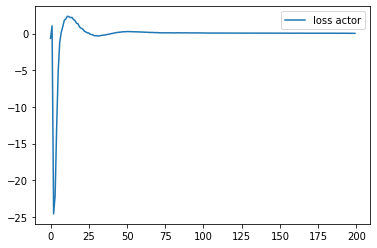

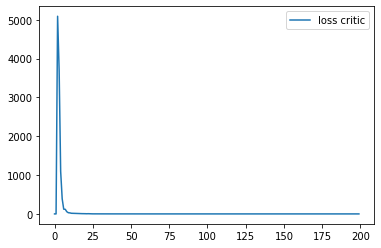

[VALIDATION]


100%|██████████| 13915/13915 [00:04<00:00, 3185.35it/s]


min reward episode:  -33.222592594466775
max reward episode:  0.9805271954256507
avg reward episode:  0.5927153273043971
total_loss  5.063966751098633 | actor_loss  0.024014541879296303 | critic_loss  5.039952278137207


100%|██████████| 13915/13915 [00:05<00:00, 2539.98it/s]


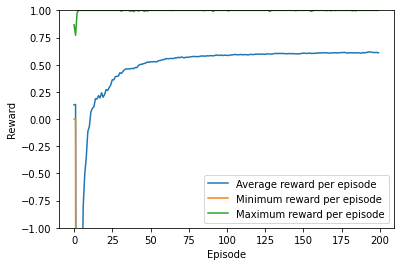

In [9]:
# train
rewards_episodes_avg, rewards_episodes_min, rewards_episodes_max = train(train_env, learning_rate_actor, learning_rate_critic, state_size, action_size, hidden_size, max_episodes, gamma, load_models=False)

# test
val(test_env)
test(test_env)

visualize(rewards_episodes_avg, rewards_episodes_min, rewards_episodes_max)
#env.close()

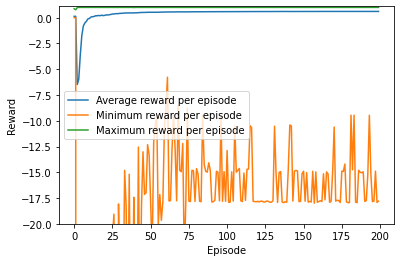

In [21]:
visualize(rewards_episodes_avg, rewards_episodes_min, rewards_episodes_max)